In [ ]:
## Задание 2. SQL
## Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.
## NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [ ]:
SELECT COUNT(*) AS best_students
FROM (SELECT st_id, COUNT(*) AS correct_answers
      FROM peas
      WHERE correct = true
      AND date_trunc('month', timest) = (SELECT date_trunc('month', max(timest)) FROM peas)
GROUP BY st_id
HAVING COUNT(*) >= 20) sub_q;

In [ ]:
WITH active_users AS (
  SELECT st_id
  FROM peas
  WHERE correct = true
  GROUP BY st_id
  HAVING COUNT(*) > 10),
 
active_math AS (
  SELECT st_id
  FROM peas
  WHERE correct = true
    AND subject = 'Math'
  GROUP BY st_id
  HAVING COUNT(*) >= 2)
  
SELECT
  s.test_grp,
  COUNT(DISTINCT s.st_id) AS users_total,
  SUM(fp.money) AS revenue,
  SUM(fp.money)/ COUNT(DISTINCT s.st_id) AS ARPU,
  COUNT(DISTINCT au.st_id) AS active_users,
  SUM(fp.money)/COUNT(DISTINCT au.st_id) AS ARPAU,
  CAST(COUNT(DISTINCT fp.st_id) AS FLOAT) / COUNT(DISTINCT s.st_id) AS CR_to_purchase,
  CAST(COUNT (DISTINCT CASE 
                          WHEN au.st_id IS NOT NULL AND fp.st_id IS NOT NULL THEN s.st_id 
                          END) AS FLOAT) / COUNT(DISTINCT au.st_id) AS CR_AU_to_purchase,
  COUNT(DISTINCT am.st_id) AS active_math_users,
  CAST(COUNT(DISTINCT CASE
                         WHEN am.st_id IS NOT NULL AND fp.subject = 'Math' THEN s.st_id
                         END) AS FLOAT) / COUNT(DISTINCT am.st_id) AS CR_math_active_to_purchase
FROM studs s
LEFT JOIN active_users au ON au.st_id = s.st_id
LEFT JOIN final_project_check fp ON fp.st_id = s.st_id
LEFT JOIN active_math  am   ON am.st_id = s.st_id
GROUP BY s.test_grp
ORDER BY s.test_grp;

In [ ]:
##Задание 1. A/B–тестирование

In [ ]:
## Предлагаем вам ответить на следующие вопросы:

## На какие метрики вы смотрите в ходе анализа и почему?
## Имеются ли различия в показателях и с чем они могут быть связаны?
## Являются ли эти различия статистически значимыми?
## Стоит ли запускать новую механику на всех пользователей?

In [1]:
import pandas as pd
import numpy as np
from operator import attrgetter
import matplotlib.pylab as plt
import seaborn as sns

In [ ]:
## Загружаем файлы, указывая, где необходимо разделители, выводим первые несколько строк таблиц, 
## чтобы быстро посмотреть, что в них внутри, и размер таблиц.

In [3]:
groups = pd.read_csv("groups.csv", sep = ";")

In [4]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
groups.shape

(74484, 2)

In [6]:
groups_add = pd.read_csv("groups_add.csv")

In [7]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [8]:
groups_add.shape

(92, 2)

In [9]:
active_studs = pd.read_csv("active_studs.csv")

In [10]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [11]:
active_studs.shape

(8341, 1)

In [12]:
checks = pd.read_csv("checks.csv", sep = ";")

In [13]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [ ]:
checks.shape

In [ ]:
## Oбъединяем 2 датафрейма с данными о пользователях, выводим новый размер таблицы - проверяем себя.

In [14]:
all_groups = pd.concat([groups, groups_add])
all_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [15]:
all_groups.shape

(74576, 2)

In [ ]:
## Смотрим распределение пользоваталей по группам, т.е. какая доля данных относится к каждой группе.

In [16]:
all_groups.value_counts(subset = "grp", normalize = True)

grp
B    0.80298
A    0.19702
dtype: float64

In [18]:
## Контрольная группа (A) только 20%
## Тестовая группа (B) около 80 %
## это значит что -> неравномерное распределение, т.к. тестовая группа почти в 4 раза больше контрольной.

SyntaxError: invalid syntax (<ipython-input-18-82f604ff2347>, line 3)

In [ ]:
## Обогатим датасет информацией о пользователях, которые зашли на платформу в дни проведения эксперимента:
## у каждого пользователя появляется флаг активен (True) он или нет (False).

In [19]:
groups_copy = all_groups.copy()

In [20]:
groups_copy["active"] = groups_copy["id"].isin(active_studs["student_id"])

In [21]:
groups_copy

,id,grp,active
0,1489,B,False
1,1627,A,True
2,1768,B,False
3,1783,B,False
4,1794,A,False
...,...,...,...
87,200247820,B,False
88,201032527,B,False
89,201067612,B,False
90,201067653,B,False


In [ ]:
## К каждому пользователю подтянем его оплаты из таблицы checks (если были).

In [22]:
groups_copy = groups_copy.merge(checks, how = "left", left_on = "id", right_on = "student_id")

In [23]:
groups_copy

,id,grp,active,student_id,rev
0,1489,B,False,NaN,NaN
1,1627,A,True,1627.0,990.0
2,1768,B,False,NaN,NaN
3,1783,B,False,NaN,NaN
4,1794,A,False,NaN,NaN
...,...,...,...,...,...
74571,200247820,B,False,NaN,NaN
74572,201032527,B,False,NaN,NaN
74573,201067612,B,False,NaN,NaN
74574,201067653,B,False,NaN,NaN


In [ ]:
## Оставим в таблице groups_copy только нужные 4 столбца.

In [24]:
groups_copy = groups_copy[["id","grp","active","rev"]]

In [25]:
groups_copy.head()

,id,grp,active,rev
0,1489,B,False,NaN
1,1627,A,True,990.0
2,1768,B,False,NaN
3,1783,B,False,NaN
4,1794,A,False,NaN


In [28]:
## Посмотрим, есть ли активные пользователи, которые не попали в тестирование

In [29]:
active_not_in_test = active_studs[~active_studs["student_id"].isin(groups_copy["id"])].sum()
active_not_in_test

student_id    0
dtype: int64

In [ ]:
## Посмотрим, есть ли пользователи с оплатой, которые не попали в тестирование

In [30]:
payers_not_in_test = checks[~checks["student_id"].isin(groups_copy["id"])].sum()
payers_not_in_test

student_id    0.0
rev           0.0
dtype: float64

In [ ]:
## Посмотрим, есть ли пользователи с оплатой, у которых не было активности

In [31]:
no_activity_checks = groups_copy.query("active == False and rev > 0")
no_activity_checks["grp"].value_counts()

B    120
A     29
Name: grp, dtype: int64

In [ ]:
## Среди пользователей, у которых не было активности (active == False), но при этом есть оплата (rev > 0), нашлись следующие случаи:
## в группе B — 120 человек
## в группе A — 29 человек.

## Посмотрим распредедение по группам для пользователей no_activity_checks.

In [32]:
no_activity_checks["grp"].value_counts(normalize = True)

B    0.805369
A    0.194631
Name: grp, dtype: float64

In [33]:
## Распределение по группам такое же ,как и во всем датасете - > 
## можем удалить оплативших студентов, у которых не было активности, но есть оплата.

In [ ]:
## Удалим пользователей no_activity_checks из датасета и проверим размер таблицы.

In [34]:
groups_copy = groups_copy.drop(no_activity_checks.index)

In [35]:
groups_copy.shape

(74427, 4)

In [ ]:
## Посчитаем основные метрики:

## ARPU - показывает, сколько в среднем приносит один активный пользователь (включая неплательщиков) 
## и помогает понять, увеличивает ли новая механика оплаты REV на пользователя.

## ARPPU - показывает, сколько в среднем приносит один платящий пользователь - и помогает понять, меняется ли 
## средний чек среди тех, кто уже совершает оплату (не просто начали платить чаще, а платят больше за 1 оплату).

## CR из активного в платящего - помогает понять, увеличивает ли новая механика долю людей, 
## которые переходят в оплату.

In [36]:
pivot = groups_copy.groupby("grp", as_index = False).agg(users = ("id", "nunique"), 
                                                         active_users = ("active","sum"),
                                                         paying_users = ("rev","count"), rev_sum = ("rev","sum"),
                                                         ARPPU = ("rev","mean")).rename({"grp":"group"}, axis=1)

In [37]:
pivot["ARPU"] = pivot["rev_sum"] / pivot["active_users"]
pivot["CR"] = pivot["paying_users"]/pivot["active_users"]

In [38]:
pivot

,group,users,active_users,paying_users,rev_sum,ARPPU,ARPU,CR
0,A,14664,1538,78,72820.0000,933.589744,47.347204,0.050715
1,B,59763,6803,314,394974.0035,1257.878992,58.058798,0.046156


In [40]:
## Всего было отобрано 74 427 пользователей для эксперимента --->
## Контрольная группа (A) - 14 664 (20%) + Тестовая группа (B) - 59 763 (80%).

## Cовершили активность на сайте 8 341 пользователь, а оплату совершил 541 пользователь.

## 149 пользователей, совершивших оплату без аквтиности, были удалены, тк они распределены по группам так же, 
## как и во всём датасете, и не создают перекоса в сторону одной из групп.

## В ходе анализа были выбраны след. метрики для расчета: ARPPU, ARPU, CR для active_users.

In [ ]:
## Средний чек среди активных платящих пользователей (ARPPU) вырос на ~34.7% в тестовой группе (B) по сравнению с контрольной группой (A).
## Посмотрим, являются ли эти различия статистически значимыми.

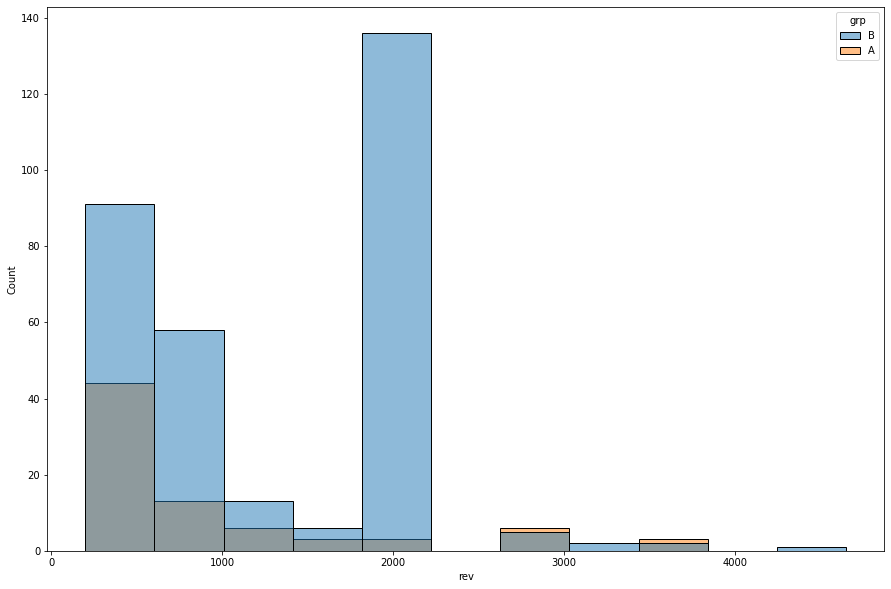

In [41]:
plt.figure(figsize=(15, 10))
sns.histplot(data = groups_copy, x = "rev", hue = "grp")

In [ ]:
## В тестовой группе (B) видно появление более крупных чеков. Проверим на нормальность и сравним дисперсии.

In [45]:
## Опишем гипотезы и интерпретируем результаты теста на нормальность Шапиро-Уилка (эффективен для средних выборок).

## H0: распределение rev внутри каждой группы (A и B) нормальное.
## H1: распределение rev внутри каждой группы (A и B) не является нормальным.

In [43]:
import pingouin as pg

In [44]:
pg.normality(groups_copy[groups_copy["rev"].notna()], dv="rev", group="grp", method='shapiro', alpha=0.05)

,W,pval,normal
A,0.735324,1.498682e-10,False
B,0.854724,1.543702e-16,False


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [ ]:
## p-value в обеих группах меньше 0.05 → отвергаем H0 (столбец normal = False) подтверждает это же.
## Распределения не нормальные.

In [ ]:
## Опишем гипотезы и интерпретируем результаты теста Левена на равентсво дисперсий.
## H0: дисперсии в группах (A и B) равны.
## H1: дисперсии в группах (A и B) не равны.

In [46]:
groups_copy.groupby("grp")["rev"].describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,78.0,933.589744,919.932711,199.0,290.00,585.0,1114.75,3660.0
B,314.0,1257.878992,790.864254,199.0,511.75,1140.0,1900.00,4650.0


In [47]:
pg.homoscedasticity(groups_copy[groups_copy["rev"].notna()], dv="rev", group="grp")

,W,pval,equal_var
levene,3.075682,0.080257,True


In [ ]:
## p-value 0.08 > 0.05 -> принимаем H0 -> дисперсии равны -> разброс в группах сопоставим.

In [ ]:
## Поскольку распределение rev НЕ нормальное,но дисперсии равны, корректный тест -> тест Манна - Уитни.

In [ ]:
## Опишем гипотезы и интерпретируем результаты теста Манна-Уитни в контексте сравнения ARPPU между группами A и B.
## H0: новая механика не влияет на средний чек платящих.
## H1: новая механика влияет на средний чек платящих.

In [49]:
groups_copy_A = groups_copy.loc[groups_copy["grp"] == "A","rev"].dropna()
groups_copy_B = groups_copy.loc[groups_copy["grp"] == "B","rev"].dropna()

In [64]:
from scipy.stats import mannwhitneyu

In [65]:
u_stat, p_val_two = mannwhitneyu(groups_copy_A, groups_copy_B, alternative='two-sided')
print(f" Тест Манна-Уитни U (двусторонний): U={u_stat:.0f}, p={p_val_two:.4g}")

 Тест Манна-Уитни U (двусторонний): U=9001, p=0.0002511


In [55]:
## p-value значительно меньше 0.05 -> отвергаем нулевую гипотезу H0 -> распределение платежей статистически значимо отличается между группами A и B.

## ВЫВОД: новая механика оплаты (группа B) привела к статистически значимому росту среднего чека среди активных платящих пользователей.

In [ ]:
## Средний чек всех аквтиных пользователей (ARPU) вырос примерно на 22.7% в тестовой группе (B) по сравнению с контрольной группой (A).
## Посмотрим, являются ли эти различия статистически значимыми.

In [ ]:
## Заполняем NaN (пропуски) 0

In [72]:
groups_copy["rev"] = groups_copy["rev"].fillna(0)
groups_copy.head()

,id,grp,active,rev
0,1489,B,False,0.0
1,1627,A,True,990.0
2,1768,B,False,0.0
3,1783,B,False,0.0
4,1794,A,False,0.0


In [ ]:
## Оставляем только активных пользователей

In [74]:
groups_active = groups_copy[groups_copy["active"]].copy()
groups_active.head()

,id,grp,active,rev
1,1627,A,True,990.0
10,2085,B,True,0.0
12,2215,B,True,0.0
43,3391,A,True,0.0
45,3401,B,True,0.0


In [ ]:
## Посмотрим структуру распределения REV по группам A и B.

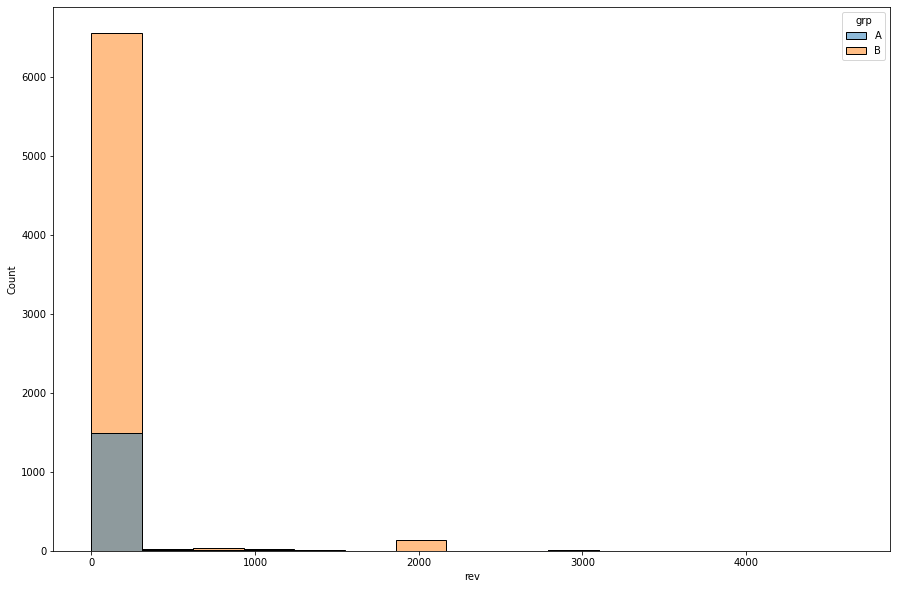

In [77]:
plt.figure(figsize=(15, 10))
sns.histplot(data = groups_active, x = "rev", hue = "grp")

In [ ]:
## в группе B пользователей в разы больше.

In [79]:
groups_active.groupby("grp")["rev"].describe()

,count,mean,std,min,25%,50%,75%,max
grp,,,,,,,,
A,1538.0,47.347204,290.490632,0.0,0.0,0.0,0.0,3660.0
B,6803.0,58.058798,313.770201,0.0,0.0,0.0,0.0,4650.0


In [ ]:
## Стандартное отклонение в 6 больше среднего -> распределение крайне ненормальное, с сильно вытянутым хвостом.

In [ ]:
## Опишем гипотезы и интерпретируем результаты теста Левена на равентсво дисперсий.
## H0: дисперсии в группах (A и B) равны.
## H1: дисперсии в группах (A и B) не равны.

In [80]:
pg.homoscedasticity(groups_active, dv="rev", group="grp")

,W,pval,equal_var
levene,1.501461,0.220481,True


In [ ]:
## p-value 0.22 > 0.05 -> принимаем H0 -> дисперсии равны -> разброс в группах сопоставим.

In [ ]:
## Опишем гипотезы и интерпретируем результаты теста Манна-Уитни в контексте сравнения ARPU между группами A и B.
## H0: новая механика не влияет на средний чек активных.
## H1: новая механика влияет на средний чек активных.

In [84]:
group_A = groups_active.loc[groups_active["grp"] == "A", "rev"]
group_B = groups_active.loc[groups_active["grp"] == "B", "rev"]

In [85]:
u_stat, p_value = mannwhitneyu(group_A, group_B, alternative='two-sided')
print("Mann–Whitney (двусторонний): U =", u_stat, ", p-value =", p_value)

Mann–Whitney (двусторонний): U = 5252113.0 , p-value = 0.5099747992861601


In [ ]:
## p-value значительно больше 0.05 -> принимаем нулевую гипотезу H0 -> новая механика не влияет на средний чек активных.

##ВЫВОД: новая механика не привела к статистически значимой разнице среднего чека среди активных пользователей.

In [ ]:
##Доверительный интервал пересекает 0 -> мы не можем отвергнуть нулевую гипотезу.

In [66]:
## z-test для сравнения конверсий между двумя независимыми группами при достаточном размере выборки.

In [70]:
## Опишем гипотезы и интерпретируем результаты z-теста для сравнения конверсий.
## H0: конверсии (CR) в группах A и B равны.
## H1: конверсии (CR) в группах A и B различаются.

In [67]:
from statsmodels.stats.proportion import proportions_ztest

In [68]:
count = pivot["paying_users"].values
nobs = pivot["active_users"].values
stat, pval = proportions_ztest(count, nobs)

In [69]:
round(pval,2)

0.45

In [71]:
## p-value > 0.05, принимаем H0 -> новая механика не увеличила (и не ухудшила) вероятность того, что активный пользователь заплатит.
## Конверсия из активного в платящего НЕ изменилась в тестовой группе B относительно контрольной группы А.

In [ ]:
## ВЫВОДЫ:

## ARPPU в группе B значимо выше, что говорит о большем среднем чеке среди платящих при новой механике.
## ARPU без статистически значимых отличий.
## Конверсия (CR) между A и B также статистически не различается.


## ВЫВОД: механика не нанесла вреда и улучшила монетизацию существующих плательщиков (ARPPU),
## но не повлияла на долю платящих (CR), поэтому итоговый бизнес-эффект (ARPU) пока не доказан.

In [ ]:
## Рекомендации: можно использовать как безопасную основу и в следующем эксперименте сфокусироваться именно на росте CR, 
## чтобы конвертировать эффект в значимый прирост ARPU.

In [ ]:
## Задание 3. Python
## Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv 
## (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
## Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [ ]:
## ИСПОЛЬЗОВАЛА ChatGPT при решении данного задания.

In [88]:
def updated_function(groups, group_add): # фyнкция, которая принимает 2 таблицы
    groups_updated = pd.concat([groups, group_add], ignore_index=True) # склеивает 2 таблицы в 1
    df = active_studs.merge(groups_updated, left_on='student_id', right_on='id')\ # cоединяем с активными пользователями
        .merge(checks, how='left', on='student_id')[['student_id', 'grp','rev']]\ # и платежами, убираем пропуски
        .fillna(value=0)
    df['paying'] = df['rev'].apply(lambda x: 1 if x>0 else 0) # помечаем тех, кто платил, и нет
    df_group_updated = df.groupby('grp', as_index=False)\
        .agg(users=('rev', 'count'), paying_users=('paying', 'sum'), revenue=('rev', 'sum'))
    df_group_updated['ARPU'] = df_group_updated['revenue']/df_group_updated['users']
    df_group_updated['ARPPU'] = df_group_updated['revenue']/df_group_updated['paying_users']
    df_group_updated['CR'] = df_group_updated['paying_users']/df_group_updated['users']
    
    return df_group_updated

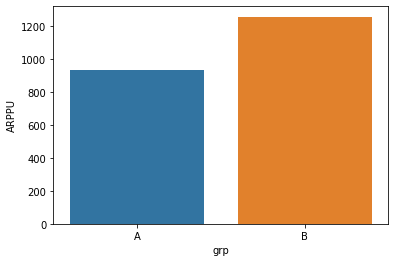

In [90]:
#ARPPU
df_group_updated = updated_function(groups, groups_add)
sns.barplot(data=df_group_updated, x='grp', y='ARPPU')

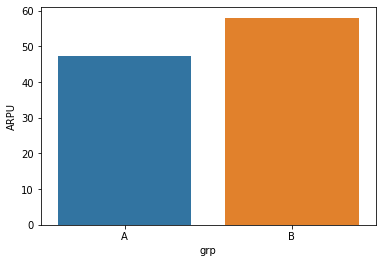

In [92]:
#ARPU
df_group_updated = updated_function(groups, groups_add)
sns.barplot(data=df_group_updated, x='grp', y='ARPU')

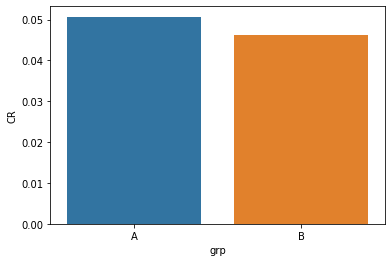

In [93]:
## CR
df_group_updated = updated_function(groups, groups_add)
sns.barplot(data=df_group_updated, x='grp', y='CR')